Comparing the Sei and DeepSEA Beluga model performance for the 2,002 chromatin profiles they share (from Roadmap Epigenomics and ENCODE). 

In [1]:
from collections import defaultdict
import glob
import os

import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('seaborn-white')

import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)

mpl.rc('axes', titlesize=14)
mpl.rc('legend', fontsize=12)

In [3]:
DATA_DIR = './sei_data'
FIGS_DIR = './figures'

DEEPSEA_PRED_DIR = os.path.join(DATA_DIR, 'beluga_evaluation')  
SEI_PRED_DIR = os.path.join(DATA_DIR, 'sei_evaluation')

In [4]:
profiles = []
with open(os.path.join(
        DATA_DIR, 'deepsea_beluga', 'chromatin_profiles.txt'), 'r') as fh:
    for p in fh:
        profiles.append(p.strip())

In [5]:
deepsea_preds = np.load(os.path.join(
    DEEPSEA_PRED_DIR, 'test_predictions.npz'))['data']
sei_preds = np.load(os.path.join(
    SEI_PRED_DIR, 'test_predictions.npz'))['data']

deepsea_tgts = np.load(os.path.join(
    DEEPSEA_PRED_DIR, 'test_targets.npz'))['data']

`unmapped_ixs` is a set of 54 sequences where Sei's input sequence length of 4096 bp exceeded the genomic coordinate's boundaries. We exclude these sequences in the evaluation so that we are computing ROC AUC and AUPRC on the identical set of sequences and chromatin profile labels for both models.

In [6]:
unmapped_ixs = np.load(
    os.path.join(DATA_DIR, 'unmapped_ixs_to_sei_seqs.npy'))
ixs = list(range(len(deepsea_preds)))
ixs = np.delete(ixs, unmapped_ixs)

In [7]:
deepsea_preds = deepsea_preds[ixs]
deepsea_tgts = deepsea_tgts[ixs]

In [8]:
def performance_metrics(predictions, targets):
    profile_aucs = {
        'Transcription Factor': [],
        'Chromatin Accessibility': [],
        'Histone Mark': []}
    profile_auprcs = {
        'Transcription Factor': [],
        'Chromatin Accessibility': [],
        'Histone Mark': []}
    
    for ix, (p, t) in enumerate(zip(predictions.T, targets.T)):
        if len(np.unique(t)) == 1 or np.sum(t) < 25:
            continue
        profile = profiles[ix]
        auc = roc_auc_score(t, p)
        auprc = average_precision_score(t, p)
        
        key = None
        if 'Histone' in profile or ('H' == profile.split('|')[1][0] and
                                    str.isdigit(profile.split('|')[1][1])):
            key = 'Histone Mark'
        elif 'dnase' in str.lower(profile):
            key = 'Chromatin Accessibility'
        else:
            key = 'Transcription Factor'
        profile_aucs[key].append(auc)
        profile_auprcs[key].append(auprc)
    return profile_aucs, profile_auprcs

In [9]:
deepsea_aucs, deepsea_auprcs = performance_metrics(
    deepsea_preds, deepsea_tgts)

In [10]:
sei_aucs, sei_auprcs = performance_metrics(
    sei_preds, deepsea_tgts)

In [11]:
colors = {
    'Transcription Factor': '#4b006e',
    'Histone Mark': '#03719c', 
    'Chromatin Accessibility': '#fe4b03'
}

In [12]:
def model_comparison(deepsea_perf, sei_perf, metric, savefile):
    plt.figure(figsize=(6, 6))
    for key, deepsea_data in deepsea_perf.items():
        sei_data = sei_perf[key]
        print(key, len(deepsea_data))
        plt.scatter(
            deepsea_data, sei_data, label=key,
            marker='o', s=6, alpha=0.5, color=colors[key])
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
    leg = plt.legend(markerscale=2)
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('DeepSEA Beluga {0}'.format(metric),
               fontsize=14)
    plt.ylabel('Sei {0}'.format(metric),
               fontsize=14)
    plt.savefig(os.path.join(FIGS_DIR, savefile), dpi=400)
    plt.show()

Transcription Factor 682
Chromatin Accessibility 334
Histone Mark 978


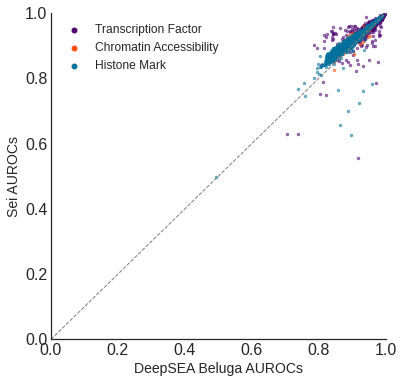

In [13]:
model_comparison(deepsea_aucs,
                 sei_aucs,
                 'AUROCs',
                 'sei_deepsea_comparison.AUROCs.png')

Transcription Factor 682
Chromatin Accessibility 334
Histone Mark 978


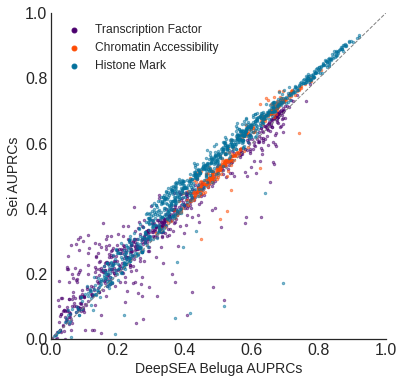

In [14]:
model_comparison(deepsea_auprcs,
                 sei_auprcs,
                 'AUPRCs',
                 'sei_deepsea_comparison.AUPRCs.png')